# Import libraries

In [ ]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

# Define constants

In [3]:
c = 299792.458
H0 = 75

# Functions

In [4]:


def scale_factor(z):
    return 1/(1+z)

z = 0.1
a = scale_factor(z)
H0 = 75
omega_DE = 0.669
omega_M = 1 - omega_DE
c = 299792.458

def Friedmann_eq(z, omega_DE):
    omega_M = 1 - omega_DE
    a = scale_factor(z)
    return H0*np.sqrt(omega_M/(a**3) + omega_DE + (1-omega_M-omega_DE)/(a**2))

def integrand(z, omega_DE):
    return c/Friedmann_eq(z, omega_DE)

def co_moving_dist(z_up, omega_DE):
    dist, err = scp.integrate.quad(integrand, 0, z_up, args = omega_DE)
    return dist

def co_moving_dist_near(z):
    return z*c/H0

#rc = co_moving_dist(z)
#print(rc)

def flux_model(omega_DE, Lp, z):
    rc = co_moving_dist(z, omega_DE)
    flux = Lp/(4*np.pi*(rc**2)*((1+z)*2))
#then convert this to magnitudes and compare with the data

#use this to find Lp using chi-sq minimisation
def flux_model_near(Lp, z):
    rc = co_moving_dist_near(z)
    flux = Lp/(4*np.pi*(rc)**2*((1+z)**2))
    return flux

# Load the data

In [5]:
sn_z_near, sn_mag_near, sn_mag_err_near =  np.loadtxt("sn_data_nearby.txt", unpack = True, usecols=(1,2,3))
sn_z_far, sn_mag_far, sn_mag_err_far =  np.loadtxt("sn_data_distant.txt", usecols=(1,2,3), unpack = True)



# Finding peak luminosity:

In [6]:
f0 = 6.61* 10**-9 * 10**(-7) * (3.2408*10**(-25))**(-2)
#6.61 * 10**(-9)
# * 10**(-7) * (0.01)**(-2) * (10**(-10))**(-1)

def mag_model_near(z, *Lpl):
    rc = co_moving_dist_near(z)
    flux = Lpl[0]/(4*np.pi*(rc)**2)
    argument = flux/f0
    #print(argument)
    mag = -2.5*np.log10(argument)
    #print(mag)
    return mag

# Chi squared mininimisation to find peak luminosity:

In [7]:
initial = np.array([1000000000]) #initial guess for L_peak_lambda
deg_freedom = sn_z_near.size - initial.size #change x to actual data values
popt, cov = scp.optimize.curve_fit(mag_model_near, # function to fit
                                     sn_z_near, # x data
                                     sn_mag_near, # y data
                                     sigma=sn_mag_err_near, # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial, # starting point for fit
                                     check_finite=True)
# define variables
print(popt)
def chisq(model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - mag_model_near(x_data[i], *model_params))/y_err[i])**2 
        # NOTE again the asterisk (*) before 'model_params' here!
    return chisqval

chisq_min = chisq(popt, sn_z_near, sn_mag_near, sn_mag_err_near)
reduced_chisq_min = chisq_min/deg_freedom
print(reduced_chisq_min)
popt_errs = np.sqrt(np.diag(cov))
Lpl_err = popt_errs[0]
for i in range(len(popt)):
    print('optimised parameter[{}] = {} +/- {}'.format(i, popt[i], popt_errs[i]))
print(chisq_min)

[2.95680692e+32]
1.400409070540853
optimised parameter[0] = 2.9568069214936652e+32 +/- 1.2650797448988194e+31
23.8069541991945


<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
C:\Users\milan\AppData\Local\Temp\ipykernel_18776\2169587312.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("${L_{\lambda, peak}}$ ${(W Å^{-1})}$")


17


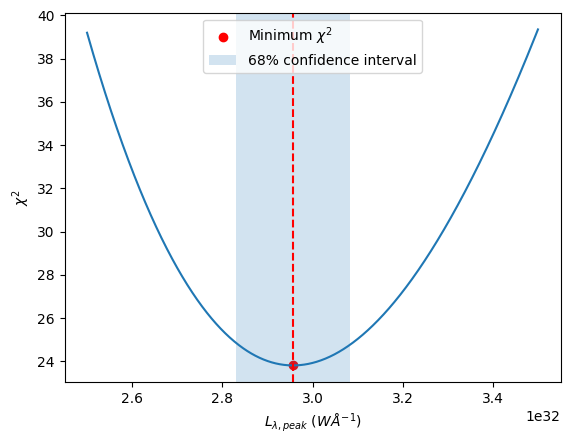

In [18]:
Lpeak_trial_vals = np.linspace(2.5*10**32, 3.5*10**32, 1000)
chisq_vals = np.zeros(len(Lpeak_trial_vals))
for i in range(len(Lpeak_trial_vals)):
    trial_Lpeak_val = np.array([Lpeak_trial_vals[i]])
    chisq_vals[i] = chisq(np.array(trial_Lpeak_val), sn_z_near, sn_mag_near, sn_mag_err_near)
print(deg_freedom)
red_chisq_vals = chisq_vals/deg_freedom
plt.figure(1)
plt.plot(Lpeak_trial_vals, chisq_vals)
plt.xlabel("${L_{\lambda, peak}}$ ${(W Å^{-1})}$")
plt.ylabel("${χ^{2}}$")
min_chisq = np.min(chisq_vals)
optimised_Lpl = Lpeak_trial_vals[np.argmin(chisq_vals)]
plt.scatter(optimised_Lpl, min_chisq, label = "Minimum ${χ^{2}}$", color = "red")
plt.axvline(optimised_Lpl, 0, color = "red", linestyle = "--")
min_chisq_plus = min_chisq + 1
min_chisq_minus = min_chisq - 1
plt.axvspan(optimised_Lpl - Lpl_err, optimised_Lpl + Lpl_err, alpha = 0.2, label = "68% confidence interval")
plt.legend()
plt.savefig("LPeakLambda-chiSquared-graph")
plt.show()

# Plotting mag-redshift data

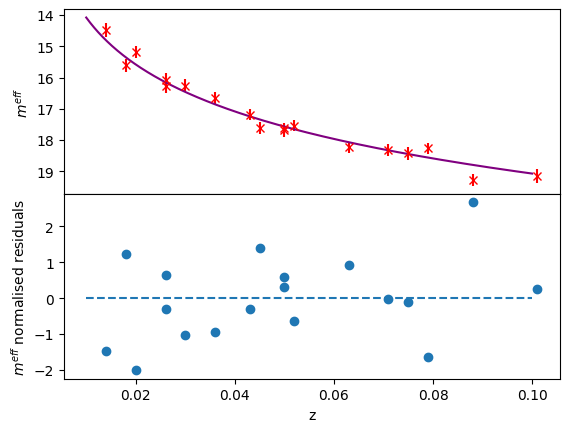

In [17]:
def zero_funct(x):
    return 0*x
trial_z = np.linspace(0.01, 0.1, 1000)
trial_mag = mag_model_near(trial_z, *popt)

norm_resid = (sn_mag_near - mag_model_near(sn_z_near, *popt))/sn_mag_err_near
fig, axs = plt.subplots(2, 1, sharex = True)
axs[0].errorbar(sn_z_near, sn_mag_near, yerr=sn_mag_err_near, marker = "x", linestyle = 'None', color = "red")
axs[0].plot(trial_z, trial_mag, color = "purple")
#axs[0].errorbar(sn_z_far, sn_mag_far, yerr=sn_mag_err_far, marker = "x", linestyle = 'None', color = "blue", label = "distant SN")
axs[1].scatter(sn_z_near, norm_resid)
axs[1].plot(trial_z, zero_funct(trial_z), linestyle = "dashed")
plt.xlabel("z")
axs[0].set_ylabel("${m^{eff}}$")
plt.ylabel("${m^{eff}}$ normalised residuals")
fig.subplots_adjust(hspace=0)
#axs[0].legend()
axs[0].invert_yaxis()
plt.savefig("effMagNearby-redshift-normResid-graph")
plt.show()

# Chi-squared minimisation to find energy densities of matter and dark energy

In [ ]:
initial = np.array([0.7]) #initial guess for L_peak_lambda
deg_freedom = sn_z_near.size - initial.size #change x to actual data values
popt, cov = scp.optimize.curve_fit(mag_model_near, # function to fit
                                     sn_z_near, # x data
                                     sn_mag_near, # y data
                                     sigma=sn_mag_err_near, # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial, # starting point for fit
                                     check_finite=True)
# define variables
def chisq(model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - mag_model_near(x_data[i], *model_params))/y_err[i])**2 
        # NOTE again the asterisk (*) before 'model_params' here!
    return chisqval

chisq_min = chisq(popt, sn_z_near, sn_mag_near, sn_mag_err_near)
reduced_chisq_min = chisq_min/deg_freedom
print(reduced_chisq_min)
popt_errs = np.sqrt(np.diag(cov))
for i in range(len(popt)):
    print('optimised parameter[{}] = {} +/- {}'.format(i, popt[i], popt_errs[i]))